In [10]:
import autograd.numpy as np
import matplotlib.pyplot as plt

from lib.functions import sample_trajectory
from lib.lqr import iLQR
from lib.models.dynamics import VanDerPolDynamics
from lib.models.measurements import PoissonMeasurement
from lib.models.priors import GaussianPrior
from lib.plotters import *

plt.style.use(["lib/style.mplstyle"])

In [11]:
num_steps = 200

Nx = 2
Nu = 2
Ny = 20

In [12]:
dynamics = VanDerPolDynamics(mu=2.0)

x1_prior = GaussianPrior(
    Nx,
    np.zeros(Nx),
    np.eye(Nx)
)

u_cov = np.array([[dynamics.dt**3/3, dynamics.dt**2/2],
                  [dynamics.dt**2/2, dynamics.dt]])
input_prior = GaussianPrior(Nu, np.zeros(Nu), u_cov)

C = np.zeros((Ny, Nx))
for i in range(Ny):
    if np.random.uniform() <= 0.5:
        C[i, 0] = 0.5
    else:
        C[i, 1] = -0.5
meas_model = PoissonMeasurement(Ny, mean_func=lambda x, t : np.exp(C@x))

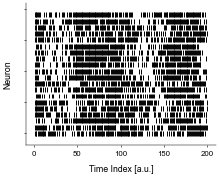

In [13]:
# Generate ground truths
true_xs, true_us, ys = sample_trajectory(
    dynamics,
    meas_model,
    input_prior,
    x1_prior,
    num_steps,
)

plot_spikes(ys)

In [14]:
# Run iLQR
ilqr = iLQR(
    dynamics,
    meas_model,
    input_prior,
    x1_prior
)
us_init = [input_prior.sample(t) for t in range(num_steps)]
ilqr_xs, ilqr_us = ilqr(ys, us_init, print_iters=True)

iLQR 0/100: Cost = 6982.004424361137


/home/finn/IIB/Project/ilqr4inference/lib/models/dynamics.py:126: RuntimeWarning: overflow encountered in double_scalars
  return np.array([[0, 1], [-1 - self.mu*x[0]*x[1], self.mu]])
/home/finn/IIB/Project/ilqr4inference/lib/models/dynamics.py:133: RuntimeWarning: invalid value encountered in matmul
  return (np.eye(self.Nx) + self.dt*self._A(x))@x + self._B()@u
/home/finn/.local/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/home/finn/IIB/Project/ilqr4inference/lib/models/measurements.py:131: RuntimeWarning: invalid value encountered in multiply
  return np.sum(y*np.log(m) - m)
/home/finn/.local/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/home/finn/IIB/Project/ilqr4inference/lib/models/measurements.py:131: RuntimeWarning: invalid value encountered in subtract
  return np.sum(y*np.log(m) - m)
/home/finn/IIB/Project

iLQR 1/100: Cost = 3826.9507436338613
iLQR 2/100: Cost = 2437.8475271317234
iLQR 3/100: Cost = 2111.6002821418
iLQR 4/100: Cost = 2073.2545679509226
iLQR 5/100: Cost = 2058.468145680981
iLQR 6/100: Cost = 2053.4898416997594
iLQR 7/100: Cost = 2051.4076199749957
iLQR 8/100: Cost = 2050.394256311962
iLQR 9/100: Cost = 2049.8246847710984
iLQR 10/100: Cost = 2049.4632679814836
iLQR 11/100: Cost = 2049.217348455946
iLQR 12/100: Cost = 2049.041977134084
iLQR 13/100: Cost = 2048.913897331098
iLQR 14/100: Cost = 2048.8197376766752
iLQR 15/100: Cost = 2048.751075311393
iLQR 16/100: Cost = 2048.7017924679276
iLQR 17/100: Cost = 2048.667212344132
iLQR 18/100: Cost = 2048.643651739149
iLQR 19/100: Cost = 2048.628188078192
iLQR 20/100: Cost = 2048.6185334453235
iLQR 21/100: Cost = 2048.612930609734
iLQR 22/100: Cost = 2048.610060250927
iLQR 23/100: Cost = 2048.6089565069456
iLQR 24/100: Cost = 2048.608931542247


Text(0.5, 0, 'time')

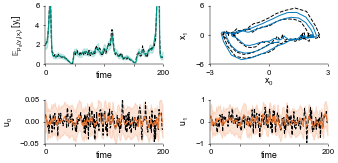

In [15]:
fig, ((ax_ys, ax_zs), (ax_u0s, ax_u1s)) = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(5, 2.5),
    layout="tight",
    gridspec_kw={"height_ratios" : [2, 1.5]}
)

plot_groundtruths([ax_ys], [meas_model.h(true_xs[t], t) for t in range(num_steps)])
plot_measurements([ax_ys], meas_model, ilqr_xs, c="#009988", ls="-", label="ilqr")
ax_ys.set_ylabel(r"$\mathbb{E}_{p_\theta(y_t|x_t)} \, [y_t]$", labelpad=10)
ax_ys.set_yticks([0, 2, 4, 6])
ax_ys.set_ylim(0, 6)
ax_ys.set_xticks([0, 50, 100, 150, 200])
ax_ys.set_xticklabels([0, None, None, None, 200])
ax_ys.set_xlabel("time", labelpad=-5)
ax_ys.set_xlim(0, 200)

ax_zs.plot(
    [x[0] for x in true_xs],
    [x[1] for x in true_xs],
    c="k",
    ls="--",
)
ax_zs.plot(
    [x.mean[0] for x in ilqr_xs],
    [x.mean[1] for x in ilqr_xs],
    c="#0077BB",
)
ax_zs.set_xlabel(r"$x_0$", labelpad=0)
ax_zs.set_ylabel(r"$x_1$", labelpad=5)
ax_zs.set_xlim(-3, 3)
ax_zs.set_xticks([-3, 0, 3])
ax_zs.set_ylim(-6, 6)
ax_zs.set_yticks([-6, 0, 6])

plot_groundtruths([ax_u0s, ax_u1s], true_us)
plot_gaussians([ax_u0s, ax_u1s], ilqr_us, c="#EE7733", label="ilqr")
ax_u0s.set_ylabel(r"$u_0$", labelpad=5)
ax_u0s.set_ylim(-0.05, 0.05)
ax_u0s.sharex(ax_ys)
ax_u0s.set_xlabel("time", labelpad=-5)
ax_u1s.set_ylabel(r"$u_1$", labelpad=5)
ax_u1s.set_ylim(-1, 1)
ax_u1s.sharex(ax_ys)
ax_u1s.set_xlabel("time", labelpad=-5)